# Flights Analysis
The goal of this post is to visualize flights taken from Google location data using Python
* We will create a .gif progressing through individual flights and a .png of all flights
* This post utilizes code from Tyler Hartley's [visualizing location history blog post](http://beneathdata.com/how-to/visualizing-my-location-history/) 


# Overview 

1. Setup
    * download data
    * install modules
2. Data Wrangling
    * data extraction
    * data exploration
    * data manipulation
3. Flight Algorithm
4. Visualize Flights
    * create individual .png of each flight to combine into .gif
    * create .png of all flights plotted at once
5. Conclusion

# Setup
1. Use Google Takout to download your Google location history
* If you've previously enabled Google location reporting on your smartphone, your GPS data will be periodically uploaded to [Google's servers](https://support.google.com/accounts/answer/3118687?hl=en&visit_id=1-636109809748631344-4285616029&rd=1). Use Google Takeout to download your location history.
    * The decisions of when and how to upload this data are entirely obfuscated to the end user, but as you'll see below, Android appears to upload a GPS location every 60 seconds. That's plenty of data to work with.
2. After downloading your data, install the required modules

## Google Takeout
Google [Takeout](https://takeout.google.com/settings/takeout) is a Google service that allows users to export any personal Google data. We'll use Takeout to download our raw location history as a one-time snapshot. Since Latitude was retired, no API exists to access location history in real-time. 

Download location data:
* Go to [takeout](https://www.google.com/settings/takeout). Uncheck all services except "Location History" 
* The data will be in a json format, which works great for us. Download it in your favorite compression type.
* When Google has finished creating your archive, you'll get an email notification and a link to download. 
* Download and unzip the file, and you should be looking at a `LocationHistory.json` file. Working with location data in [Pandas](http://pandas.pydata.org/). Pandas is an incredibly powerful tool that simplifies working with complex datatypes and performing statistical analysis in the style of R. Chris Albon has great primers on using Pandas [here](http://chrisalbon.com/#Python) under the "Data Wrangling" section.

## Install modules
* If you use Anaconda to manage your Python packages, I recommend creating a virtual environment with anaconda to install the dependencies. Copying the lines below the instruction into the terminal creates the environment, requirements.txt, etc.
    * conda create -n test-env python=3.5 anaconda
    * source activate test-env
* make a requirements.txt file for dependencies 
    * (echo descartes; echo IPython; echo shapely; echo fiona; echo Basemap) >> requirements.txt  
* install requirements.txt
    * conda install --yes --file requirements.txt
* Windows users:
    * create a python2.7 environment to install relevant modules
        * conda create -n py27 python=2.7 anaconda
        * source activate py27
    * Download and install [Microsoft Visual C++ Compiler for Python 2.7 ](https://www.microsoft.com/EN-US/DOWNLOAD/DETAILS.ASPX?ID=44266)
    * install fiona, Shapely, GDAL, descartes, and basemap from https://www.lfd.uci.edu/~gohlke/pythonlibs/

After completing the setup, we'll read in the `LocationHistory.json` file from Google Takeout and create a DataFrame.

In [1]:
from __future__ import division
from utils import * 

# Data Wrangling

## Data Extraction

In [2]:
with open('data/LocationHistory/2018/LocationHistory.json', 'r') as location_file:
    raw = json.loads(location_file.read())

# use location_data as an abbreviation for location data
location_data = pd.DataFrame(raw['locations'])
del raw #free up some memory

# convert to typical units
location_data['latitudeE7'] = location_data['latitudeE7']/float(1e7) 
location_data['longitudeE7'] = location_data['longitudeE7']/float(1e7)

# convert timestampMs to seconds
location_data['timestampMs'] = location_data['timestampMs'].map(lambda x: float(x)/1000) 
location_data['datetime'] = location_data.timestampMs.map(datetime.datetime.fromtimestamp)

# Rename fields based on the conversions
location_data.rename(columns={'latitudeE7':'latitude',
                              'longitudeE7':'longitude',
                              'timestampMs':'timestamp'}, inplace=True)

# Ignore locations with accuracy estimates over 1000m
location_data = location_data[location_data.accuracy < 1000]
location_data.reset_index(drop=True, inplace=True)

## Explore Data
* view data and datatypes

In [3]:
print(location_data.dtypes)
location_data.describe()

accuracy                     int64
activity                    object
altitude                   float64
heading                    float64
latitude                   float64
longitude                  float64
timestamp                  float64
velocity                   float64
verticalAccuracy           float64
datetime            datetime64[ns]
dtype: object


,accuracy,altitude,heading,latitude,longitude,timestamp,velocity,verticalAccuracy
count,745660.000000,101260.000000,44100.000000,745660.000000,745660.000000,7.456600e+05,58874.000000,4921.000000
mean,58.997173,67.057525,186.597551,37.748367,-102.506537,1.417774e+09,7.769678,23.099776
std,125.358984,242.209547,101.643968,9.004123,23.609836,3.356510e+07,11.790783,45.139324
min,1.000000,-715.000000,0.000000,13.689757,-123.260751,1.376790e+09,0.000000,2.000000
25%,22.000000,-18.000000,98.000000,29.817569,-122.306596,1.391259e+09,0.000000,2.000000
50%,31.000000,2.000000,181.000000,29.986634,-95.246060,1.413249e+09,1.000000,2.000000
75%,50.000000,60.000000,270.000000,47.664284,-94.995603,1.428049e+09,13.000000,30.000000
max,999.000000,6738.000000,359.000000,50.105984,23.782015,1.519330e+09,208.000000,473.000000


* accuracy code "999" may represent missingness  
* find earliest and latest observations in the data
    * save for later

In [4]:
print("earliest observed date: {}".format(min(location_data["datetime"]).strftime('%m-%d-%Y')))
print("latest observed date: {}".format(max(location_data["datetime"]).strftime('%m-%d-%Y')))

earliest_obs = min(location_data["datetime"]).strftime('%m-%d-%Y')
latest_obs = max(location_data["datetime"]).strftime('%m-%d-%Y')

earliest observed date: 08-17-2013
latest observed date: 02-22-2018


## Data manipulation

### Degrees and Radians

* We're going to convert the degree-based geo data to radians to calculate distance traveled. I'm going to paraphrase an explanation (source below) about why the degree-to-radians conversion is necessary
    * Degrees are arbitrary because they’re based on the sun and backwards because they are from the observer’s perspective.
    * Radians are in terms of the mover allowing equations to “click into place”. Converting rotational to linear speed is easy, and ideas like sin(x)/x make sense.
 
Consult [this post](https://betterexplained.com/articles/intuitive-guide-to-angles-degrees-and-radians/) for more info about degrees and radians in distance calculation.
    
* convert degrees to radians

In [5]:
degrees_to_radians = np.pi/180.0 
location_data['phi'] = (90.0 - location_data.latitude) * degrees_to_radians 
location_data['theta'] = location_data.longitude * degrees_to_radians

# Compute distance between two GPS points on a unit sphere
location_data['distance'] = np.arccos(np.sin(location_data.phi)*np.sin(location_data.phi.shift(-1)) * 
                                      np.cos(location_data.theta - location_data.theta.shift(-1)) +  
                                      np.cos(location_data.phi)*np.cos(location_data.phi.shift(-1))) * 6378.100 
# 6378.100  is the radius of earth in km

* calculate speed during trips (in km/hr)

In [6]:
location_data['speed'] = (location_data.distance/
                          (location_data.timestamp - location_data.timestamp.shift(-1))*3600)

* Make a new dataframe containing the difference in location between each pair of points. 
* Any one of these pairs is a potential flight

In [7]:
flight_data = pd.DataFrame(data=
                           {'end_lat':location_data.latitude,
                            'end_lon':location_data.longitude,
                            'end_datetime':location_data.datetime,
                            'distance':location_data.distance,
                            'speed':location_data.speed,
                            'start_lat':location_data.shift(-1).latitude,
                            'start_lon':location_data.shift(-1).longitude,
                            'start_datetime':location_data.shift(-1).datetime,
                           }).reset_index(drop=True)

* Now flightdata contains a comparison of each adjacent GPS location. 
* All that's left to do is filter out the true flight instances from the rest of them.

### spherical distance function
* distance_on_unit_sphere: function to calculate straight-line distance traveled on a sphere
* see utils.py for function documentation

# Flight algorithm
* filter flights
    * remove flights using conservative selection criteria

In [8]:
flights = flight_data[(flight_data.speed > 40) & (flight_data.distance > 80)].reset_index()

# Combine instances of flight that are directly adjacent 
# Find the indices of flights that are directly adjacent
_f = flights[flights['index'].diff() == 1]
adjacent_flight_groups = np.split(_f, (_f['index'].diff() > 1).nonzero()[0])

# Now iterate through the groups of adjacent flights and merge their data into
# one flight entry
for flight_group in adjacent_flight_groups:
    idx = flight_group.index[0] - 1 #the index of flight termination
    flights.loc[idx, ['start_lat', 'start_lon', 'start_datetime']] = [flight_group.iloc[-1].start_lat, 
                                                         flight_group.iloc[-1].start_lon, 
                                                         flight_group.iloc[-1].start_datetime]
    # Recompute total distance of flight
    flights.loc[idx, 'distance'] = distance_on_unit_sphere(flights.loc[idx].start_lat,
                                                           flights.loc[idx].start_lon,
                                                           flights.loc[idx].end_lat,
                                                           flights.loc[idx].end_lon)*6378.1   

# Now remove the "flight" entries we don't need anymore.
flights = flights.drop(_f.index).reset_index(drop=True)

# Finally, we can be confident that we've removed instances of flights broken up by
# GPS data points during flight. We can now be more liberal in our constraints for what
# constitutes flight. Let's remove any instances below 200km as a final measure.
flights = flights[flights.distance > 200].reset_index(drop=True)

This algorithm worked nearly 100% of the time for me with less than 5 false positives or negatives; however, the adjacency-criteria of the algorithm is fairly brittle. The core of it centers around the assumption that inter-flight GPS data will be directly adjacent to one another. That's why the initial screening on line 1 of the previous cell had to be so liberal.

Now, the flights DataFrame contains only instances of true flights which facilitates plotting with Matplotlib's Basemap. If we plot on a flat projection like tmerc, the drawgreatcircle function will produce a true path arc just like we see in the in-flight magazines.

# Visualize Flights

* Reset the flight index and change index values by adding a leading 0 for index items 0-9 (e.g., 1 becomes 01)
* This new index is important for correctly ordering images as we create a gif

In [9]:
flights = flights.sort_values(by="start_datetime").reset_index()
flights["index"] = flights.index
flights["index"] = flights["index"].apply(lambda x: '{0:0>2}'.format(x))
flights.index = flights["index"]

* view the first observation in the flights dataframe

In [10]:
flights.iloc[0]

level_0                                  114
index                                     00
distance                             255.032
end_datetime      2013-09-08 11:00:26.190000
end_lat                              30.4372
end_lon                             -95.4975
speed                                117.789
start_datetime    2013-09-08 08:50:31.631000
start_lat                            32.4222
start_lon                           -96.8384
Name: 00, dtype: object

# Create .gif and .png of all flights

1. Create a folder called `flights2018` within the `output` directory to save all .pngs
2. Loop through each flight and create a .png with the following characteristics
    * the origin of the current flight is a green circle
    * the destination of the current flight is red circle
    * the current flight is gold
    * previous flights are purple
        + the origin and destination of previous flights are black circles
3. The .png of all flights loops through the flights data frame and plots each flight simultaneously

In [11]:
if not os.path.exists('output/flights2018'):
    os.makedirs('output/flights2018')

In [12]:
fig = plt.figure(figsize=(18,12))
current_date = time.strftime("printed: %a, %d %b %Y", time.localtime())

# Plotting across the international dateline is tough. 
# One option is to break up flights by hemisphere. 
# Otherwise, you'd need to plot using a different projection like 'robin' and 
# potentially center on the Int'l Dateline (lon_0=-180)
# Western Hemisphere Flights
# flights = flights[(flights.start_lon < 0) & (flights.end_lon < 0)]
# Eastern Hemisphere Flights
# flights = flights[(flights.start_lon > 0) & (flights.end_lon > 0)] 

xbuf = 0.2
ybuf = 0.35
min_lat = np.min([flights.end_lat.min(), flights.start_lat.min()])
min_lon = np.min([flights.end_lon.min(), flights.start_lon.min()])
max_lat = np.max([flights.end_lat.max(), flights.start_lat.max()])
max_lon = np.max([flights.end_lon.max(), flights.start_lon.max()])
width = max_lon - min_lon
height = max_lat - min_lat

m = Basemap(llcrnrlon=min_lon - width* xbuf,
            llcrnrlat=min_lat - height*ybuf,
            urcrnrlon=max_lon + width* xbuf,
            urcrnrlat=max_lat + height*ybuf,
            projection='merc',
            resolution='l',
            lat_0=min_lat + height/2,
            lon_0=min_lon + width/2,)

m.drawmapboundary(fill_color='#EBF4FA')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.fillcontinents()

for idx, f in flights.iterrows():
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon,
                      f.end_lat, linewidth=3, alpha=1, color='#ffd700' )
    m.plot(*m(f.start_lon, f.start_lat), color='g', alpha=0.8, marker='o')
    m.plot(*m(f.end_lon, f.end_lat), color='r', alpha=0.5, marker='o' )
    fig.text(0.125, .24, "kivanpolimis.com", color='#555555', fontsize=15, ha='left')
    fig.text(0.125,.2,
         "Plotted using Python, Basemap \n Collected from {0} to {1} on Android \n {2}".
         format(earliest_obs, latest_obs, current_date),
         ha='left', color='#555555', style='italic')
    plt.savefig('output/flights2018/flights_{}.png'.format(idx),
                dpi=150, frameon=False, transparent=False,
                bbox_inches='tight', pad_inches=0.2)
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon, f.end_lat,
                      linewidth=3, alpha=0.5, color='#800080' )
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon, f.end_lat,
                      linewidth=3, alpha=0.5, color='b' )
    m.plot(*m(f.start_lon, f.start_lat), color='k', alpha=0.8, marker='o')
    m.plot(*m(f.end_lon, f.end_lat), color='k', alpha=0.5, marker='o' )
    

* create a .gif by combing all the (ordered) .pngs in the `flights2018` directory with the glob
* use [ImageMagick](https://www.imagemagick.org/script/download.php) to create the .gif
    + ImageMagick is a free and open-source software suite for displaying, converting, and editing raster image and vector image files. It can read and write over 200 image file formats. 
    + source: https://en.wikipedia.org/wiki/ImageMagick

In [13]:
# code to create .gif from:
# http://superfluoussextant.com/making-gifs-with-python.html

gif_name = 'flights2018'
# Get all the .pngs in the `flights2018` directory
file_list = glob.glob('output/flights2018/*.png') 

# Sort the images by number
list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) 
with open('image_list.txt', 'w') as file:
    for item in file_list:
        file.write("%s\n" % item)

# On Windows convert is 'magick'
os.system('magick -loop 0 -delay "10" @image_list.txt output/{}.gif'.format(gif_name)) 

# On Unix/Mac use convert 
#os.system('convert -loop 0 -delay "10" @image_list.txt output/{}.gif'.format(gif_name))

0

In [14]:
Image(url='output/{}.gif'.format(gif_name)) 

* create .png of all flights

In [15]:
fig = plt.figure(figsize=(18,12))
current_date = time.strftime("printed: %a, %d %b %Y", time.localtime())
png_name = 'flights2018'

xbuf = 0.2
ybuf = 0.35
min_lat = np.min([flights.end_lat.min(), flights.start_lat.min()])
min_lon = np.min([flights.end_lon.min(), flights.start_lon.min()])
max_lat = np.max([flights.end_lat.max(), flights.start_lat.max()])
max_lon = np.max([flights.end_lon.max(), flights.start_lon.max()])
width = max_lon - min_lon
height = max_lat - min_lat

m = Basemap(llcrnrlon=min_lon - width* xbuf,
            llcrnrlat=min_lat - height*ybuf,
            urcrnrlon=max_lon + width* xbuf,
            urcrnrlat=max_lat + height*ybuf,
            projection='merc',
            resolution='l',
            lat_0=min_lat + height/2,
            lon_0=min_lon + width/2,)

m.drawmapboundary(fill_color='#EBF4FA')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.fillcontinents()

for idx, f in flights.iterrows():
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon, f.end_lat,
                      linewidth=3, alpha=0.4, color='b')
    m.plot(*m(f.start_lon, f.start_lat), color='g', alpha=0.8, marker='o')
    m.plot(*m(f.end_lon, f.end_lat), color='r', alpha=0.5, marker='o' )

fig.text(0.125, .24, "kivanpolimis.com", color='#555555', fontsize=15, ha='left')
fig.text(0.125,.2,
         "Plotted using Python, Basemap \n Collected from {0} to {1} on Android \n {2}".
         format(earliest_obs, latest_obs, current_date),
         ha='left', color='#555555', style='italic')
plt.savefig('output/{}.png'.format(png_name),
            dpi=150, frameon=False, transparent=False, bbox_inches='tight', pad_inches=0.2)

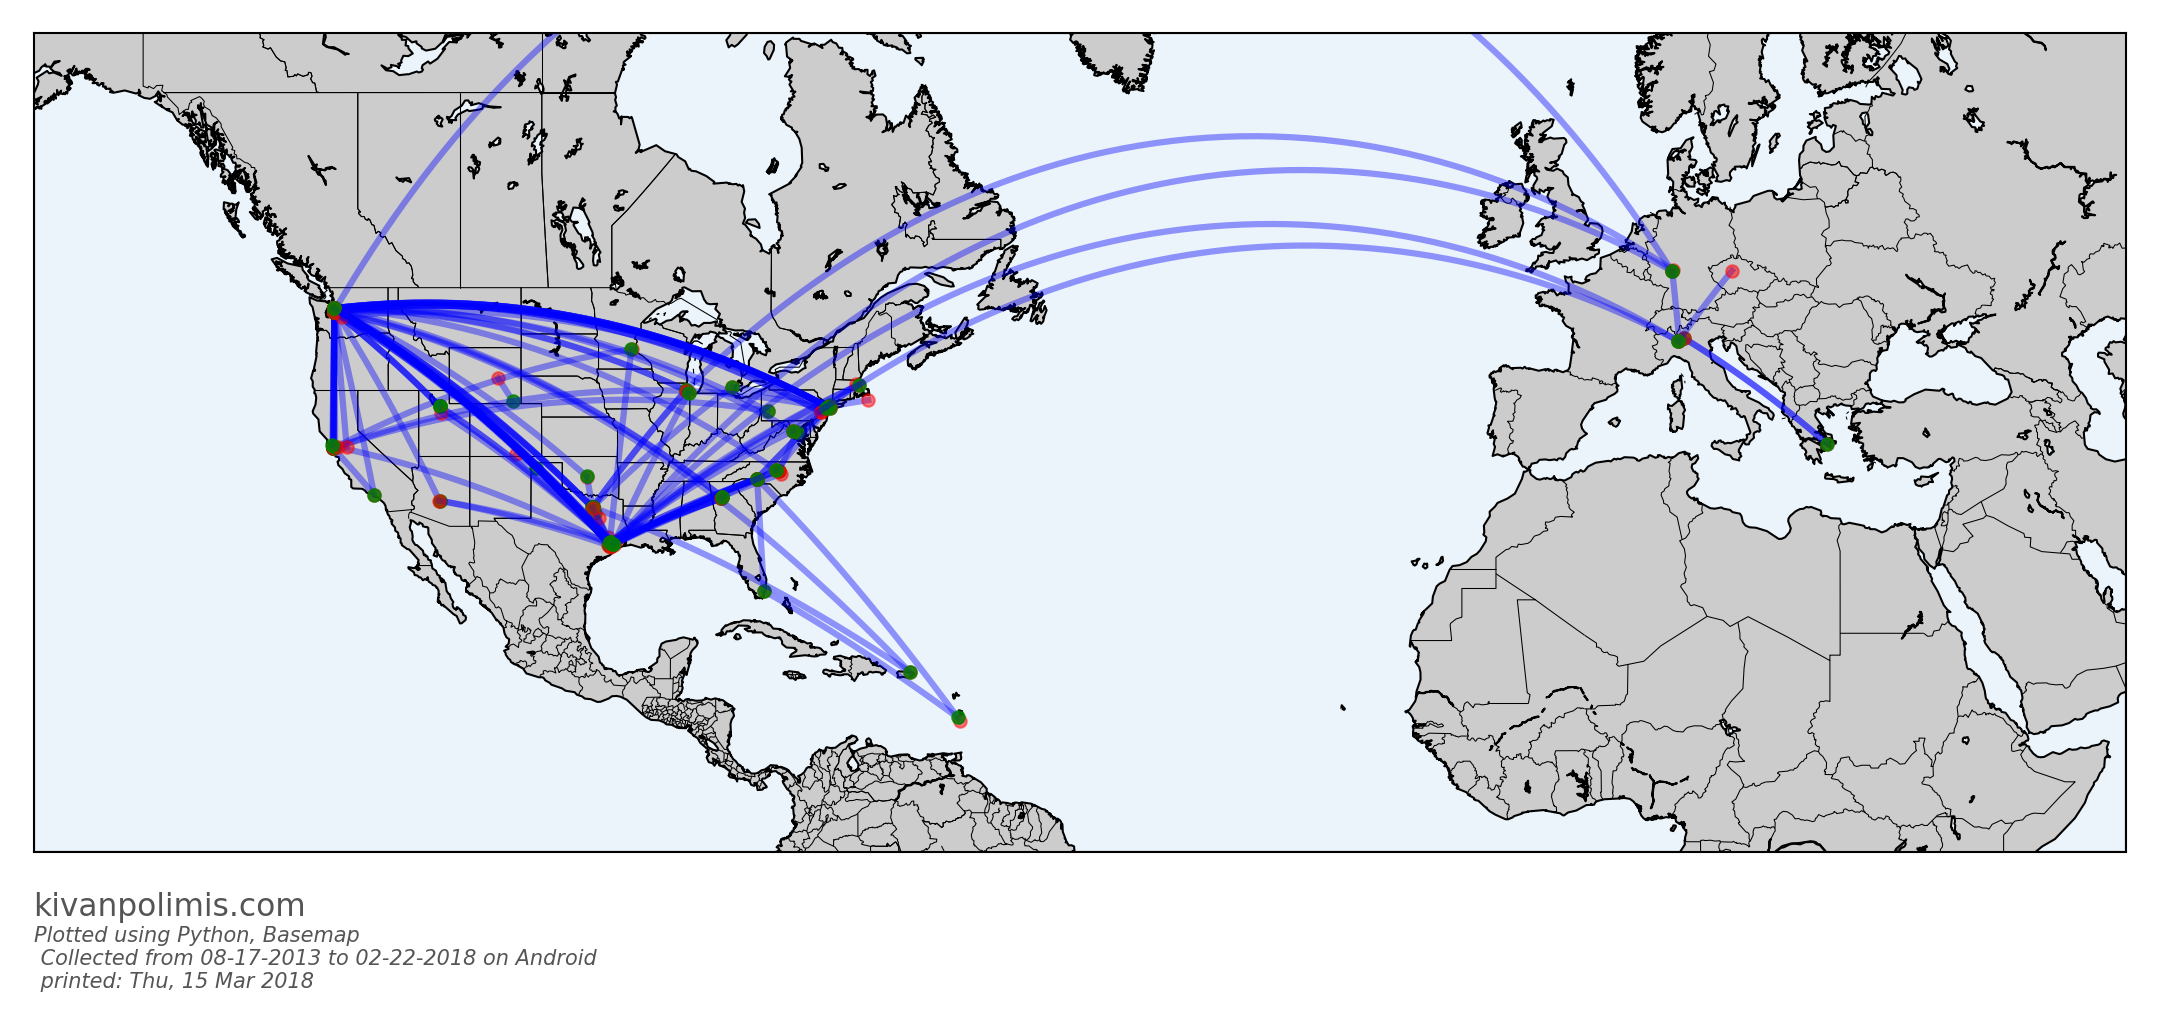

In [16]:
Image(filename='output/{}.png'.format(png_name)) 

* Calculate all the miles you have traveled in the years observed with a single line of code:

In [17]:
# distance column is in km, convert to miles
flights_in_miles = round(flights.distance.sum()*.621371) 
print("{0} miles traveled from {1} to {2}".format(flights_in_miles, earliest_obs, latest_obs))

172130.0 miles traveled from 08-17-2013 to 02-22-2018


# Conclusion
You can leverage this notebook, scripts, and cited sources to reproduce these maps.  
I'm working on creating functions to automate these visualizations

## Potential future directions
* label airports 
    + can use [open flights dataset](https://openflights.org/data.html)
* add flight information (origin, destination, etc.) in the legend of each .png that is used to create the .gif

Download this [notebook](downloads/notebooks/flights_analysis.ipynb), or see a static view [here](https://github.com/kpolimis/kpolimis.github.io/blob/master/downloads/notebooks/flights_analysis.ipynb)

In [18]:
print("System and module version information: \n")
print('Python version: \n {} \n'.format(sys.version_info))
print("last updated: {}".format(time.strftime("%a, %d %b %Y %H:%M", time.localtime())))

System and module version information: 

Python version: 
 sys.version_info(major=2, minor=7, micro=14, releaselevel='final', serial=0) 

last updated: Thu, 15 Mar 2018 04:28
